In [186]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers.pooling import AveragePooling2D
import keras
from keras.layers.core import Dropout, Flatten, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.layers import Input, Conv2D, MaxPooling2D
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import cv2
import os
import sys
from PIL import Image, ImageFilter
from easydict import EasyDict

In [211]:
print("\n\n\nDataset split is: \n81%/9%/10%, \ntrain/valid/test\n\n\n")

args = EasyDict({
    "kfold": bool(input("kfold?: ")),
    "dataset": 'Data',
    "epochs": int(input("How many epochs?: ")),
    'plot':'Test_Batch_4.png'
})




Dataset split is: 
81%/9%/10%, 
train/valid/test



kfold?: True
How many epochs?: 2


In [188]:
print("Loading  images...")

imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []

for imagePath in imagePaths:

    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    data.append(image)
    labels.append(label)

print(len(data),'total images')

Loading  images...
5164 total images


In [189]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
# convert the data and labels to NumPy arrays

data2 = np.array(data)
labels2 = np.array(labels)

lb = LabelBinarizer()
labelss = lb.fit_transform(labels2)
labelsss = to_categorical(labelss)
# Prolif : 0
# Senescent : 1

(trainX, testX, yer, testY) = train_test_split(data2, labelss,test_size=0.1, random_state=42)

(trainX, testX, trainY, testY) = train_test_split(data2, labelsss,test_size=0.1, random_state=42)


train_aug = ImageDataGenerator()
val_aug = ImageDataGenerator()


In [205]:
baseModel = keras.applications.vgg16.VGG16(
    include_top = False,
    weights = 'imagenet',
    input_tensor = None,
    input_shape = (120, 120, 3),
    pooling = None,
    classes = 2)
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(3,3))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(120, activation = 'tanh')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation = 'softmax')(headModel)

model = Model(inputs = baseModel.input, outputs = headModel)

for layer in baseModel.layers:
    layer.trainable = False

opt = Adam(lr=1e-3)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
if args.kfold == True:
    def cross_val(model,train, valid, x_test, y_test):
        H = model.fit_generator(
            train,
            validation_data = valid,
            epochs=args['epochs'], verbose = 1
        )
        return model.evaluate(x_test,y_test)[1]
    
    folds = StratifiedKFold(n_splits = 10)
    scores = []
    x = 1
    for train_index, val_index in folds.split(X = np.zeros(len(trainX)), y = yer):
        print('Round', x, '\n')
        x+=1
        x_train = trainX[train_index]
        y_train = trainY[train_index]
        x_val = trainX[val_index]
        y_val = trainY[val_index]
        train_batch = train_aug.flow(x_train, y_train, batch_size=100)
        valid_batch = val_aug.flow(x_val, y_val, batch_size = 100)
        scores.append(cross_val(model, train_batch, valid_batch, testX, testY))
    print(np.mean(scores))
    
else:
    train_batch = train_aug.flow(x_train, y_train, batch_size=100)
    valid_batch = val_aug.flow(x_val, y_val, batch_size = 100)
    H = model.fit_generator(
        train_batch,
        validation_data = valid_batch,
        epochs=args['epochs'])

[INFO] evaluating network...
              precision    recall  f1-score   support

      Prolif       0.71      0.78      0.74       261
   Senescent       0.75      0.67      0.71       256

    accuracy                           0.73       517
   macro avg       0.73      0.72      0.72       517
weighted avg       0.73      0.73      0.72       517



<Figure size 1080x1080 with 0 Axes>

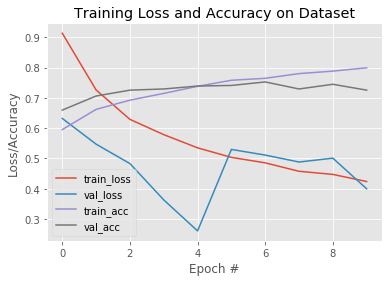

In [21]:
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=100)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=lb.classes_))
# plot the training loss and accuracy
# N = args['epochs']
N = args['epochs']
plt.figure(figsize=(15,15))
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])

In [30]:
model.evaluate(testX,testY)

517/517 [==============================] - 1s 2ms/step


[0.5236865873493586, 0.7253385186195374]